### Feedforward Nerual Network for MNIST Handwritten Digit Recognition
### Optimized for CUDA/GPU Training

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

### Check for CUDA availability

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: Quadro RTX 4000
Memory: 7.6 GB


### Set random seeds for reproducibilty

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

### Data preprocessing and loading

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

### Download and load MNIST dataset

In [5]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

### Data loaders with optimal batch size for GPU

In [6]:
batch_size = 256    # Adjusted for RTX 4000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


### Define the Feedforward Neural Network

In [7]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size = 784, hidden_sizes=[512, 256, 128], num_classes=10, dropout_rate=0.3):
        super(FeedForwardNN, self).__init__()

        layers = []
        prev_size = input_size

        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)
        
        
    def forward(self, x):
        # Flatten the input (batch_size, 1, 28, 28) --> (batch_size, 784)
        x = x.view(x.size(0), -1)
        return self.network(x)

### Initialize model and move to GPU

In [8]:
model = FeedForwardNN().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 567,434


### Loss function and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

### Training function

In [10]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}'
        })

    return running_loss / len(train_loader), 100. * correct / total

### Evaluation function

In [11]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating", leave=False):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    return test_loss / len(test_loader), 100. * correct / total

### Training loop

In [12]:
num_epochs = 20
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    # Train
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)

    # Evaluate
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

    # Update learning rate
    scheduler.step()

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")

end_time = time.time()
print(f"\nTraining completed in {end_time - start_time:.2f} seconds")

Starting training...

Epoch [1/20]


Train Loss: 0.3971, Train Acc: 87.75%
Test Loss: 0.1340, Test Acc: 95.93%
LR: 0.001000

Epoch [2/20]


Train Loss: 0.1514, Train Acc: 95.54%
Test Loss: 0.1024, Test Acc: 96.66%
LR: 0.001000

Epoch [3/20]


Train Loss: 0.1148, Train Acc: 96.62%
Test Loss: 0.0836, Test Acc: 97.38%
LR: 0.001000

Epoch [4/20]


Train Loss: 0.0939, Train Acc: 97.12%
Test Loss: 0.0696, Test Acc: 97.81%
LR: 0.001000

Epoch [5/20]


Train Loss: 0.0796, Train Acc: 97.62%
Test Loss: 0.0647, Test Acc: 97.91%
LR: 0.001000

Epoch [6/20]


Train Loss: 0.0717, Train Acc: 97.83%
Test Loss: 0.0631, Test Acc: 98.05%
LR: 0.001000

Epoch [7/20]


Train Loss: 0.0629, Train Acc: 98.04%
Test Loss: 0.0663, Test Acc: 98.12%
LR: 0.001000

Epoch [8/20]


Train Loss: 0.0593, Train Acc: 98.20%
Test Loss: 0.0633, Test Acc: 98.19%
LR: 0.001000

Epoch [9/20]


Train Loss: 0.0571, Train Acc: 98.23%
Test Loss: 0.0668, Test Acc: 97.96%
LR: 0.001000

Epoch [10/20]


Train Loss: 0.0525, Train Acc: 98.39%
Test Loss: 0.0661, Test Acc: 98.03%
LR: 0.000100

Epoch [11/20]


Train Loss: 0.0306, Train Acc: 99.06%
Test Loss: 0.0503, Test Acc: 98.56%
LR: 0.000100

Epoch [12/20]


Train Loss: 0.0254, Train Acc: 99.23%
Test Loss: 0.0498, Test Acc: 98.63%
LR: 0.000100

Epoch [13/20]


Train Loss: 0.0225, Train Acc: 99.35%
Test Loss: 0.0509, Test Acc: 98.56%
LR: 0.000100

Epoch [14/20]


Train Loss: 0.0214, Train Acc: 99.35%
Test Loss: 0.0496, Test Acc: 98.56%
LR: 0.000100

Epoch [15/20]


Train Loss: 0.0199, Train Acc: 99.40%
Test Loss: 0.0490, Test Acc: 98.50%
LR: 0.000100

Epoch [16/20]


Train Loss: 0.0173, Train Acc: 99.48%
Test Loss: 0.0489, Test Acc: 98.62%
LR: 0.000100

Epoch [17/20]


Train Loss: 0.0180, Train Acc: 99.49%
Test Loss: 0.0508, Test Acc: 98.59%
LR: 0.000100

Epoch [18/20]


Train Loss: 0.0157, Train Acc: 99.52%
Test Loss: 0.0504, Test Acc: 98.70%
LR: 0.000100

Epoch [19/20]


Train Loss: 0.0160, Train Acc: 99.54%
Test Loss: 0.0500, Test Acc: 98.66%
LR: 0.000100

Epoch [20/20]


Train Loss: 0.0141, Train Acc: 99.58%
Test Loss: 0.0502, Test Acc: 98.70%
LR: 0.000010

Training completed in 60.89 seconds


### Plot training history

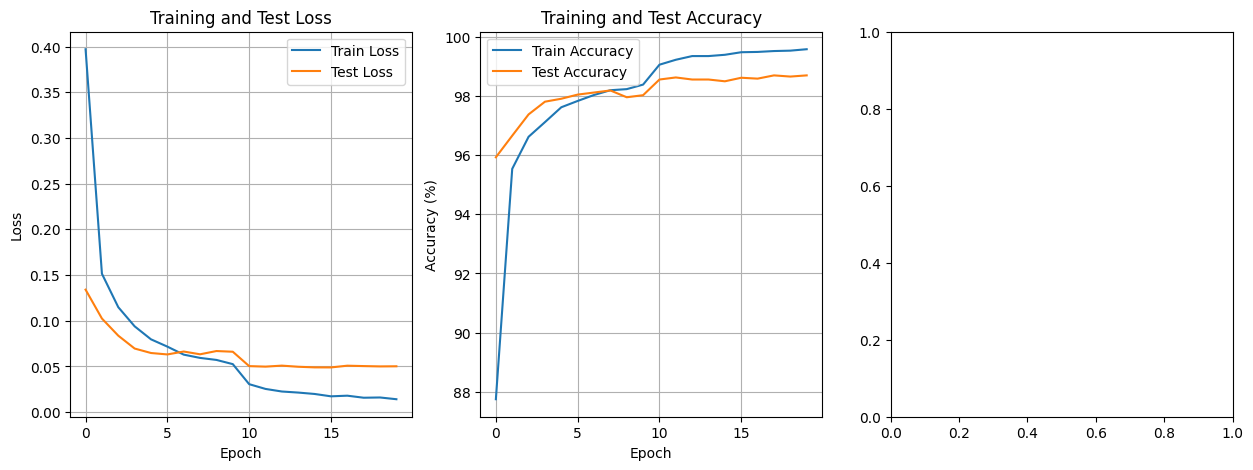

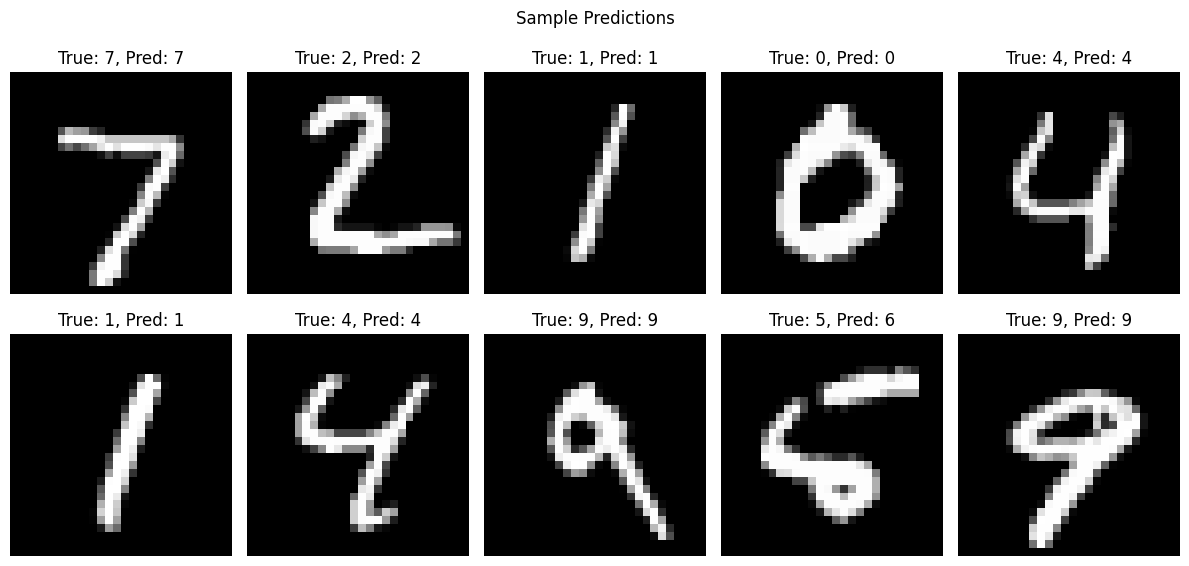

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
# Display some test images with predictions
model.eval()
with torch.no_grad():
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    output = model(data)
    _, predicted = torch.max(output, 1)

    # Show first 10 images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(10):
        ax = axes[i//5, i%5]
        img = data[i].cpu().squeeze().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {target[i].item()}, Pred: {predicted[i].item()}')
        ax.axis('off')
    plt.suptitle('Sample Predictions')

plt.tight_layout()
plt.show()

### Save the model

In [14]:
torch.save(model.state_dict(), 'ffnn_mnist_model.pth')
print("Model saved as 'ffnn_mnist_model.pth'")

Model saved as 'ffnn_mnist_model.pth'


### Final evaluation with confusion matrix

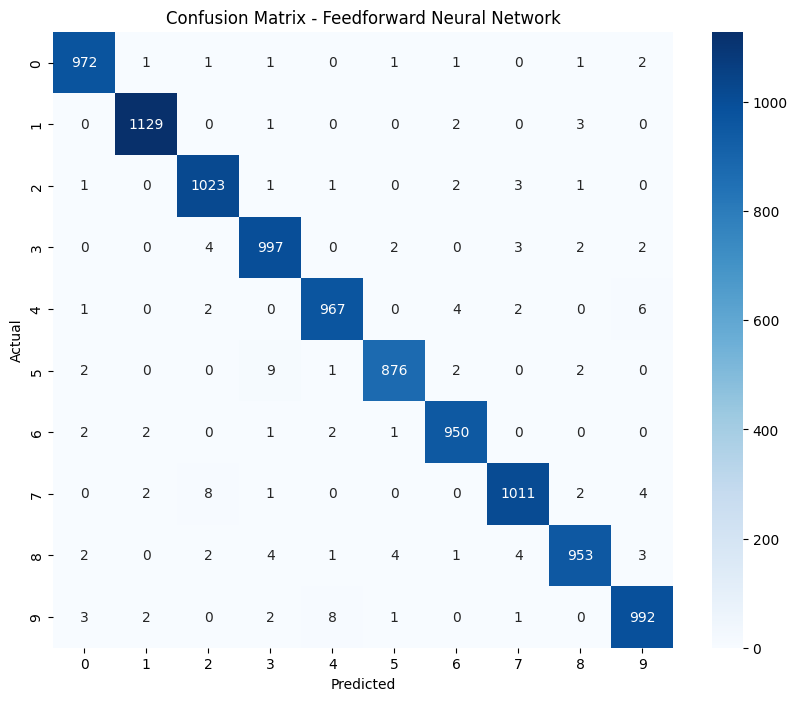


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Final Test Accuracy: 98.70%
Best Test Accuracy: 98.70%


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get all predictions for confusion matrix
all_predictions = []
all_targets = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Feedforward Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_predictions, target_names=[str(i) for i in range(10)]))

print(f"\nFinal Test Accuracy: {test_accuracies[-1]:.2f}%")
print(f"Best Test Accuracy: {max(test_accuracies):.2f}%")